In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.metrics import (precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
orders = pd.read_csv('orders.csv')
priors = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
train = pd.read_csv('order_products__train.csv')

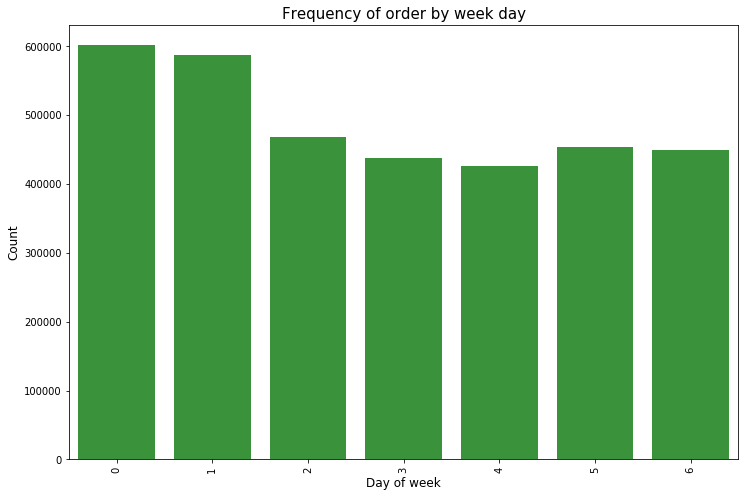

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[2])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

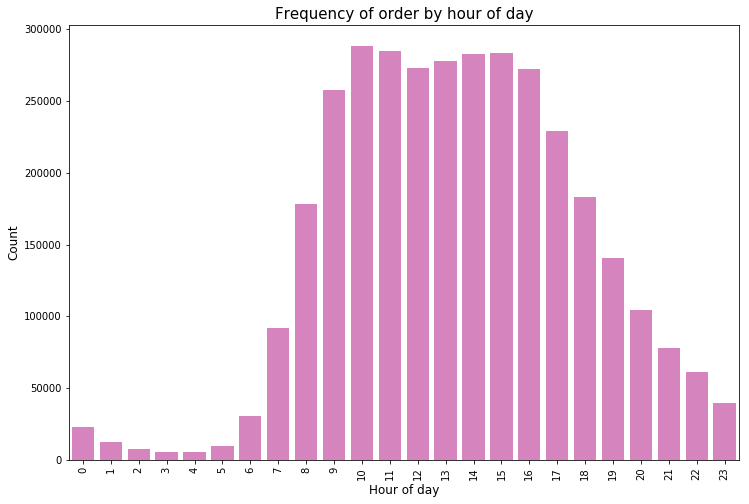

In [6]:
#The days of the week have not beed named, but for the sake of this project, we assume that 0 is Saturday and 1 is Sunday. 
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[6])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

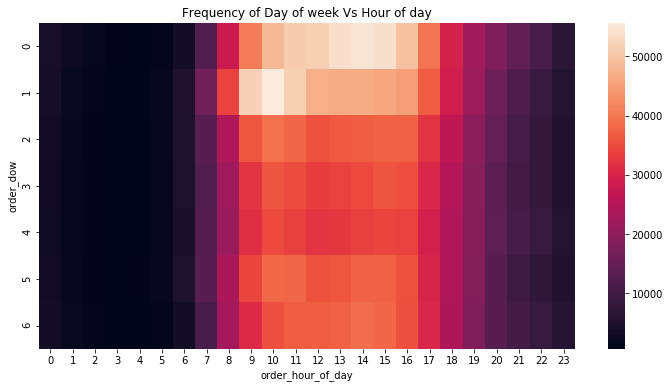

In [7]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

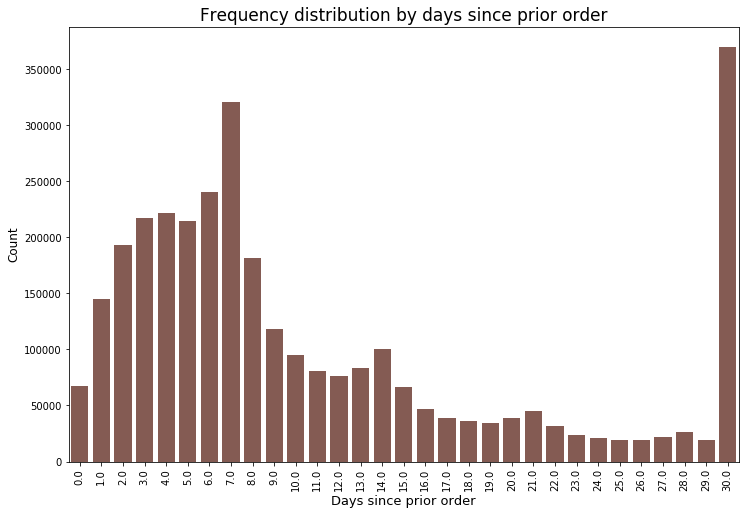

In [8]:
#It looks like Saturday evening and Sunday mornings are when people order the most
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[5])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=13)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=17)
plt.show()

In [9]:
# % of re-orders in the Prior Data Set 
priors.reordered.sum() / priors.shape[0]


0.5896974667922161

In [10]:
# % of re-orders in the Train Data Set 
train.reordered.sum() / train.shape[0]

0.5985944127509629

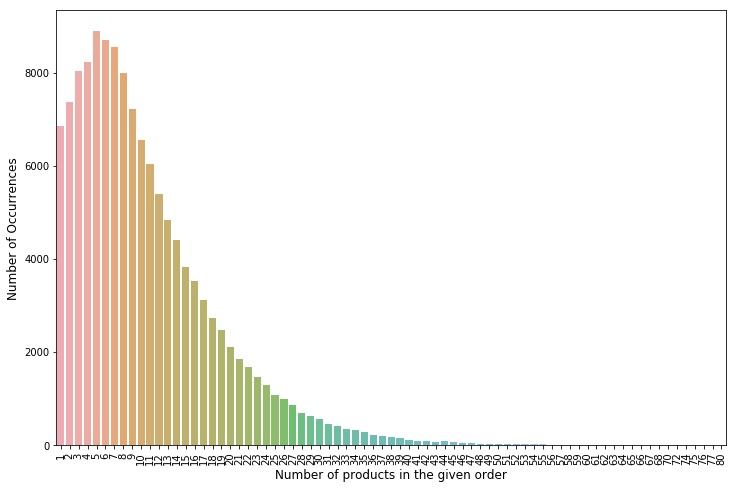

In [11]:
grouped_df = train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [22]:
order_products_prior_df = pd.merge(priors, products, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [24]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


In [25]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(15)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


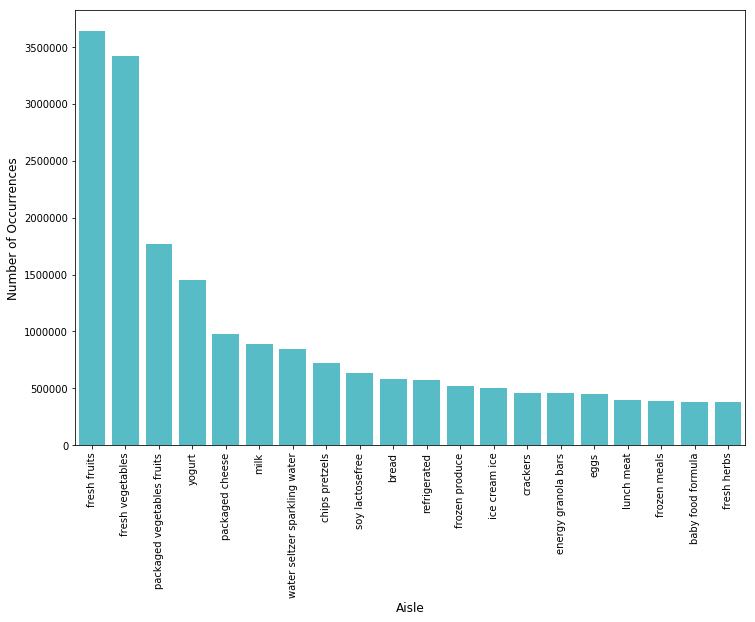

In [26]:
#It looks like people ordered a lot of Organic products, and a lot of fruits!
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[9])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

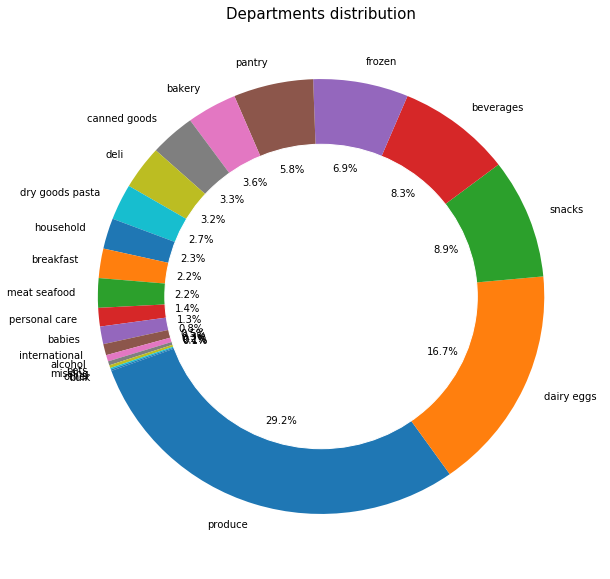

In [27]:
#Again, when reviewing the aisles, we see a lot of fruits and vegetable orders
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)


my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


plt.show()

### Clealry, produce, and dairy are the largest departments
* We are interested in the patterns of re orders, so here we explore the correlation b/w adding an item to the car, with the order ratio.
* Not surprisingly, it looks like people ended up purchasing the products that they FIRST added to their cart, compared to those that were added later.

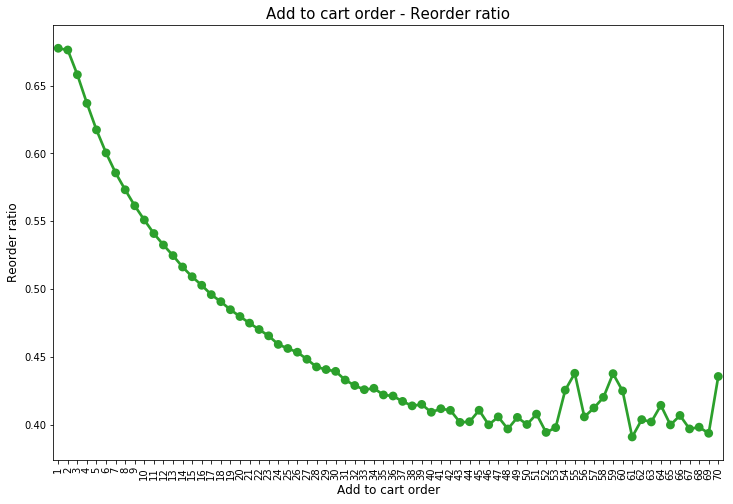

In [23]:
#take a look at this gragh
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

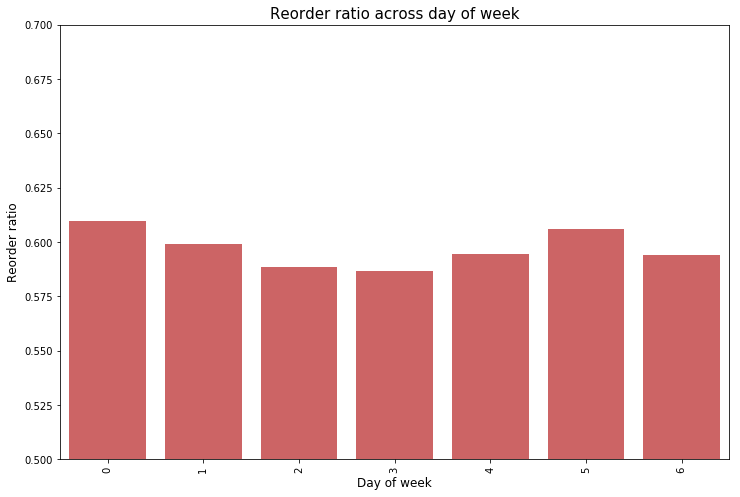

In [18]:
order_products_train_df = pd.merge(train, orders, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

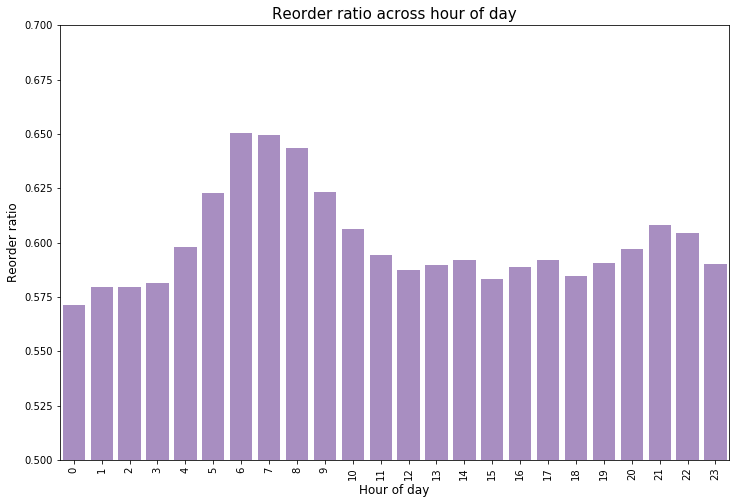

In [19]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
# Reduce the dataset to produce a smaller number of users
fracTrain = 0.05
fracTest = 0.1

# Total users,order_id in train set. This include both the actual training set and the holdout set
sampleOrdersTrain = orders[orders["eval_set"]=="train"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTrain).reset_index(drop=True)
sampleOrdersTest = orders[orders["eval_set"]=="test"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTest).reset_index(drop=True)
sampleOrders = pd.concat([sampleOrdersTrain, sampleOrdersTest], ignore_index=True)

orders = orders[orders["user_id"].isin(sampleOrders["user_id"])].reset_index(drop=True)
train = train[train["order_id"].isin(orders["order_id"])].reset_index(drop=True)
priors = priors[priors["order_id"].isin(orders["order_id"])].reset_index(drop=True)

In [5]:
len(sampleOrdersTrain)

6560

In [6]:
print('Orders: ', len(orders))
print('Priors: ', len(priors))
print('Train: ', len(train))
print('sampleOrders: ', len(sampleOrders))

Orders:  237757
Priors:  2269390
Train:  70207
sampleOrders:  14060


In [7]:
sizes = orders["eval_set"].value_counts()
sizes

prior    223697
test       7500
train      6560
Name: eval_set, dtype: int64

In [8]:
pr = priors.copy()
print(len(pr))
pr.head()

2269390


,order_id,product_id,add_to_cart_order,reordered
0,5,13176,1,1
1,5,15005,2,1
2,5,47329,3,1
3,5,27966,4,1
4,5,23909,5,1


prior    223697
test       7500
train      6560
Name: eval_set, dtype: int64


Text(0.5,1,'Count of orders in each dataset')

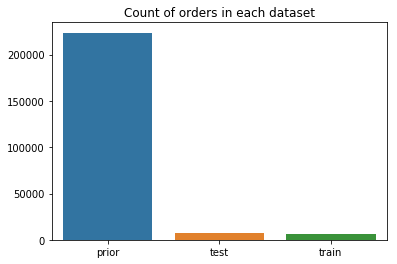

In [9]:
sizes = orders["eval_set"].value_counts()
print(sizes)
sns.barplot(x=sizes.index, y=sizes.values)
plt.title("Count of orders in each dataset")

User Behavior Features

In [10]:
#The below mentioned features are user specific(grupby:userID) #size: Number of observation
# 1. Average Days between orders
# 2. Average day of week
# 3. Average hour of the day

usr = orders.groupby('user_id')['days_since_prior_order'].mean().to_frame('avg_days_between_orders').reset_index()
dow = orders.groupby('user_id')['order_dow'].mean().to_frame('avg_order_dow').reset_index()
hod = orders.groupby('user_id')['order_hour_of_day'].mean().to_frame('avg_order_hod').reset_index()
hod['avg_order_hod'] = hod['avg_order_hod']/4
usr = usr.merge(dow, on='user_id')
usr = usr.merge(hod, on='user_id')
del dow
del hod
usr.head()

,user_id,avg_days_between_orders,avg_order_dow,avg_order_hod
0,11,18.714286,4.500000,2.718750
1,19,9.333333,4.600000,3.300000
2,21,10.454545,2.117647,2.676471
3,36,9.540541,2.921053,3.605263
4,43,11.818182,2.583333,3.708333


In [11]:
# 3. Average order size
# 4. Average Number of reorder/ cart
# for avergae caculation look at section (contd.. user feature)

order_sizes = priors.groupby(['order_id']).size().to_frame('size_order').reset_index()
order_sizes['num_reordered'] = priors['reordered'].groupby(priors['order_id']).sum().reset_index()['reordered']
order_sizes.head()

,order_id,size_order,num_reordered
0,5,26,21
1,14,11,9
2,45,1,1
3,52,5,3
4,68,9,6


In [12]:
orders['Weekend?'] = [1 if x in [0,1] else 0 for x in orders['order_dow']]
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,2411567,11,prior,1,0,11,NaN,1
1,1170872,11,prior,2,5,11,12.0,0
2,2840752,11,prior,3,5,10,14.0,0
3,1611810,11,prior,4,5,13,30.0,0
4,2921164,11,prior,5,5,11,30.0,0


### Now let's start lookin into user space
1. Number of times user ordered product
2. Frequnecy: Number of times order product/ total prior orders

In [13]:
# Create a merged table with user_id, product_id and times it has been ordered in all previous orders

# Crate dataframe for prpduct_id and User ID
t1 = priors[["order_id", "product_id"]] # get order id, product id from prior data
t2 = orders[orders["eval_set"]=="prior"][["order_id","user_id"]]# get order id, user id from order data
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1) # Combine two data and drop order_id
counts = pd.DataFrame({"Times_Ordered": df.groupby(by=["user_id","product_id"]).size()}).reset_index()

In [14]:
# Select only users in train set
# Do the same for the training set, showing all the single purchases
t1 = train[["order_id", "product_id"]]# get order id, product id from train data
t2 = orders[orders["eval_set"]=="train"][["order_id","user_id"]] # get order id, product id from order data
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1)# Combine two data and drop order_id

In [15]:
# Aggregate data by orders.
# Find out which products have been repurchased
trainUsers = orders[orders["eval_set"]=="train"]["user_id"] # Get only userid from orders table
trainCounts  = counts[counts["user_id"].isin(trainUsers)] # Get prior order details(times ordered,product_id,user_id) for coorsponsing users 

In [16]:
timesOrd_per_UsrXProd = pd.merge(trainCounts, df, on=["user_id","product_id"], how='left', indicator="Purchased") 
#Here indicator will specify whether product is mentioned in both train  and prior order

timesOrd_per_UsrXProd["Repurchased"] = np.where(timesOrd_per_UsrXProd.Purchased == "both", 1, 0)
# When it is mentioned in both it is categoriesed as 1, else it is 0

timesOrd_per_UsrXProd.drop("Purchased", 1, inplace=True)# we used purchased column to tage repurchased column and now delete

print(timesOrd_per_UsrXProd.shape)

(435912, 4)


In [17]:
# Add columns with historical frequency (number of times product has been bought divided by number of orders from user)
ordersPerUser = orders[orders["eval_set"]=="train"][["user_id","order_number"]]
ordersPerUser["numberPriorOrders"] = ordersPerUser["order_number"]-1 # Number of prior order=total orders -1
ordersPerUser.drop("order_number", 1, inplace=True)

timesOrd_per_UsrXProd = pd.merge(timesOrd_per_UsrXProd, ordersPerUser, how="left", on="user_id")

In [18]:
timesOrd_per_UsrXProd["frequency"] = timesOrd_per_UsrXProd["Times_Ordered"]/timesOrd_per_UsrXProd["numberPriorOrders"]

In [19]:
timesOrd_per_UsrXProd.head()

,user_id,product_id,Times_Ordered,Repurchased,numberPriorOrders,frequency
0,21,196,1,0,33,0.030303
1,21,2434,1,0,33,0.030303
2,21,3023,1,0,33,0.030303
3,21,3485,1,0,33,0.030303
4,21,4006,2,0,33,0.060606


In [20]:
# The order number in the train/test sets corresponds to the total number of orders in the prior set
ordersPerUser = orders[orders["eval_set"].isin(["train","test"])][["user_id","order_number"]]
ordersPerUser.rename(columns={"order_number":"tot_orders"}, inplace=True)
ordersPerUser.head()

,user_id,tot_orders
7,11,8
17,19,10
51,21,34
89,36,38
101,43,12


In [21]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,5,13176,1,1
1,5,15005,2,1
2,5,47329,3,1
3,5,27966,4,1
4,5,23909,5,1


In [22]:
#Combine Priors With Order Data
priors = pd.merge(priors, orders, on='order_id')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,5,13176,1,1,156122,prior,42,6,16,9.0,0
1,5,15005,2,1,156122,prior,42,6,16,9.0,0
2,5,47329,3,1,156122,prior,42,6,16,9.0,0
3,5,27966,4,1,156122,prior,42,6,16,9.0,0
4,5,23909,5,1,156122,prior,42,6,16,9.0,0


In [23]:
len(priors)

2269390

### Product Features:

1.Total Order of product.

2.product reorder ratio

3.product reorder probability

In [24]:
prior_sort = priors.sort_values(['user_id', 'order_number', 'product_id'], ascending=True) # Ascending sort of user id, order number, product id
prior_sort = prior_sort.assign(product_time = prior_sort.groupby(['user_id', 'product_id']).cumcount()+1) # cumulatove sum of product

In [25]:
# For calculating reorder probability

sub1 = prior_sort[prior_sort['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
#Count of all products which are order frist time (i.e. count of all records where reorder = 0)

sub2 = prior_sort[prior_sort['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')#Count of all products which are order Second time

In [26]:
# Calculate total order of one product and Reorder of that product

sub1['prod_orders'] = prior_sort.groupby('product_id')['product_id'].size() # Add Total order to data frame
sub1['prod_reorders'] = prior_sort.groupby('product_id')['reordered'].sum() # Add Total reorders to data frame
sub2   = sub2.reset_index().merge(sub1.reset_index())

In [27]:
# So now we have dataframe with product id, the first order count, second order count, count total order and sumof total number of reorders.
sub2.head()

,product_id,prod_second_orders,prod_first_orders,prod_orders,prod_reorders
0,1,19,58,162,104
1,3,3,4,10,6
2,4,7,14,32,18
3,5,1,1,7,6
4,9,3,7,11,4


In [28]:
# calculating reorder probability and ratio for the product

sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders'] /sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

In [29]:
prd.head()

,product_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,162,0.327586,0.641975
1,3,10,0.750000,0.600000
2,4,32,0.500000,0.562500
3,5,7,1.000000,0.857143
4,9,11,0.428571,0.363636


In [30]:
#Let's combine all product related features to the product dataframe
products= pd.merge(products,prd,on='product_id')
products.head()

,product_id,product_name,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,1,Chocolate Sandwich Cookies,61,19,162,0.327586,0.641975
1,3,Robust Golden Unsweetened Oolong Tea,94,7,10,0.750000,0.600000
2,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,32,0.500000,0.562500
3,5,Green Chile Anytime Sauce,5,13,7,1.000000,0.857143
4,9,Light Strawberry Blueberry Yogurt,120,16,11,0.428571,0.363636


In [31]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,5,13176,1,1,156122,prior,42,6,16,9.0,0
1,5,15005,2,1,156122,prior,42,6,16,9.0,0
2,5,47329,3,1,156122,prior,42,6,16,9.0,0
3,5,27966,4,1,156122,prior,42,6,16,9.0,0
4,5,23909,5,1,156122,prior,42,6,16,9.0,0


In [32]:
df = pd.merge(priors, order_sizes, on='order_id')
df['cart_priority'] = 1 - df['add_to_cart_order']/(df['size_order']+1)
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,size_order,num_reordered,cart_priority
0,5,13176,1,1,156122,prior,42,6,16,9.0,0,26,21,0.962963
1,5,15005,2,1,156122,prior,42,6,16,9.0,0,26,21,0.925926
2,5,47329,3,1,156122,prior,42,6,16,9.0,0,26,21,0.888889
3,5,27966,4,1,156122,prior,42,6,16,9.0,0,26,21,0.851852
4,5,23909,5,1,156122,prior,42,6,16,9.0,0,26,21,0.814815


In [33]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,size_order,num_reordered,cart_priority
0,5,13176,1,1,156122,prior,42,6,16,9.0,0,26,21,0.962963
1,5,15005,2,1,156122,prior,42,6,16,9.0,0,26,21,0.925926
2,5,47329,3,1,156122,prior,42,6,16,9.0,0,26,21,0.888889
3,5,27966,4,1,156122,prior,42,6,16,9.0,0,26,21,0.851852
4,5,23909,5,1,156122,prior,42,6,16,9.0,0,26,21,0.814815


In [34]:
#contd.. user feature
avg_sizes = df[['user_id','size_order','num_reordered']].groupby(['user_id']).mean().reset_index()
avg_sizes.rename(columns={"size_order":"avg_order_size", "num_reordered":"avg_n_reordered"}, inplace=True)
avg_sizes.head()

,user_id,avg_order_size,avg_n_reordered
0,11,13.808511,4.957447
1,19,28.431373,8.848039
2,21,7.985366,3.609756
3,36,5.509804,3.098039
4,43,14.755102,6.190476


In [35]:
timesOrdered = df.groupby(['user_id','product_id']).agg({'count','mean'})['cart_priority'].reset_index()
timesOrdered.rename(columns={"mean":"avg_cart_priority", "count":"times_ord"}, inplace=True)
timesOrdered = pd.merge(timesOrdered, avg_sizes, on='user_id')
df.drop(['cart_priority'], 1, inplace=True)

del avg_sizes

timesOrdered.head()

,user_id,product_id,times_ord,avg_cart_priority,avg_order_size,avg_n_reordered
0,11,95,1,0.545455,13.808511,4.957447
1,11,2002,1,0.571429,13.808511,4.957447
2,11,4799,1,0.187500,13.808511,4.957447
3,11,5605,1,0.636364,13.808511,4.957447
4,11,5989,1,0.437500,13.808511,4.957447


In [36]:
df = pd.merge(df, timesOrdered, on=["user_id","product_id"])
df = pd.merge(df, usr, on=['user_id'])
df = pd.merge(df, ordersPerUser, on=["user_id"])
df = pd.merge(df, products.drop('product_name',1), on="product_id")
df = df.drop('eval_set', 1)

del timesOrdered, usr, ordersPerUser

In [37]:
df["days_since_prior_order"].fillna(0,inplace=True)

In [38]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,avg_n_reordered,avg_days_between_orders,avg_order_dow,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,5,13176,1,1,156122,42,6,16,9.0,0,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
1,24234,13176,5,1,156122,5,4,13,6.0,0,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
2,35757,13176,2,1,156122,3,0,14,6.0,1,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
3,241270,13176,2,1,156122,32,5,13,2.0,0,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
4,284006,13176,1,1,156122,28,3,12,5.0,0,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479


In [39]:
print(list(df.columns))

['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'Weekend?', 'size_order', 'num_reordered', 'times_ord', 'avg_cart_priority', 'avg_order_size', 'avg_n_reordered', 'avg_days_between_orders', 'avg_order_dow', 'avg_order_hod', 'tot_orders', 'aisle_id', 'department_id', 'prod_orders', 'prod_reorder_probability', 'prod_reorder_ratio']


### Features for Train and Test Sets

In [43]:
featuresTrain = pd.merge(df, orders[orders["eval_set"]=="train"][["user_id"]],on="user_id",how="inner")

In [44]:
# Append target column
trainProducts = pd.merge(train, orders, on="order_id")[["user_id","product_id"]]
featuresTrain = pd.merge(featuresTrain, trainProducts, how="left", indicator="repurchased")
featuresTrain["repurchased"] = np.where(featuresTrain.repurchased == "both", 1, 0)
featuresTest = pd.merge(df, orders[orders["eval_set"]=="test"][["user_id"]],on="user_id",how="inner")

In [45]:
assert(featuresTrain.shape[0]+featuresTest.shape[0]==df.shape[0])
print(featuresTrain.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'Weekend?', 'size_order', 'num_reordered',
       'times_ord', 'avg_cart_priority', 'avg_order_size', 'avg_n_reordered',
       'avg_days_between_orders', 'avg_order_dow', 'avg_order_hod',
       'tot_orders', 'aisle_id', 'department_id', 'prod_orders',
       'prod_reorder_probability', 'prod_reorder_ratio', 'repurchased'],
      dtype='object')


In [46]:
len(featuresTest.columns)
print(featuresTest.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'Weekend?', 'size_order', 'num_reordered',
       'times_ord', 'avg_cart_priority', 'avg_order_size', 'avg_n_reordered',
       'avg_days_between_orders', 'avg_order_dow', 'avg_order_hod',
       'tot_orders', 'aisle_id', 'department_id', 'prod_orders',
       'prod_reorder_probability', 'prod_reorder_ratio'],
      dtype='object')


In [47]:
featuresTrain.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,avg_days_between_orders,avg_order_dow,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio,repurchased
0,5,13176,1,1,156122,42,6,16,9.0,0,...,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479,1
1,24234,13176,5,1,156122,5,4,13,6.0,0,...,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479,1
2,35757,13176,2,1,156122,3,0,14,6.0,1,...,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479,1
3,241270,13176,2,1,156122,32,5,13,2.0,0,...,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479,1
4,284006,13176,1,1,156122,28,3,12,5.0,0,...,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479,1


In [48]:
orders_train, orders_holdout = train_test_split(sampleOrdersTrain, test_size=0.25)
Xy_train = featuresTrain[featuresTrain["user_id"].isin(orders_train["user_id"])]
Xy_holdout = featuresTrain[featuresTrain["user_id"].isin(orders_holdout["user_id"])]

dropped = ["order_id","repurchased","reordered"]
y_train = Xy_train["repurchased"]
X_train = Xy_train.drop(dropped, 1)
y_holdout = Xy_holdout["repurchased"]
X_holdout = Xy_holdout.drop(dropped, 1)

In [49]:
X_train.head()

,product_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,size_order,num_reordered,...,avg_n_reordered,avg_days_between_orders,avg_order_dow,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio
0,13176,1,156122,42,6,16,9.0,0,26,21,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
1,13176,5,156122,5,4,13,6.0,0,17,11,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
2,13176,2,156122,3,0,14,6.0,1,18,12,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
3,13176,2,156122,32,5,13,2.0,0,24,22,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479
4,13176,1,156122,28,3,12,5.0,0,18,17,...,16.951396,6.673077,3.490566,3.339623,53,24,4,27093,0.717176,0.839479


### Recursive Feature Elimination (RFE) 

In [50]:
from sklearn.feature_selection import RFE

In [51]:
#RFE
NUM_FEATURES = 10
model = LogisticRegression()
rfe = RFE(model, NUM_FEATURES)
fit = rfe.fit(X_train, y_train)
print("Num Features:", fit.n_features_)
#print("Selected Features:", fit.support_)
#print("Feature Ranking:", fit.ranking_)
# calculate the score for the selected features
score = rfe.score(X_train, y_train)
print("Model Score with selected features is: ", score)

print("Review the selected features:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), list(X_train.columns.values))))

Num Features: 10
Model Score with selected features is:  0.8128234803474795
Review the selected features:
[(1, 'avg_cart_priority'), (1, 'avg_n_reordered'), (1, 'avg_order_size'), (1, 'num_reordered'), (1, 'order_number'), (1, 'prod_reorder_probability'), (1, 'prod_reorder_ratio'), (1, 'size_order'), (1, 'times_ord'), (1, 'tot_orders'), (2, 'avg_order_dow'), (3, 'order_dow'), (4, 'days_since_prior_order'), (5, 'department_id'), (6, 'avg_order_hod'), (7, 'order_hour_of_day'), (8, 'avg_days_between_orders'), (9, 'add_to_cart_order'), (10, 'Weekend?'), (11, 'aisle_id'), (12, 'prod_orders'), (13, 'product_id'), (14, 'user_id')]


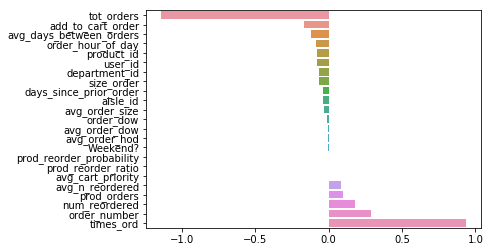

In [52]:
lr = LogisticRegression()
lr.fit(X_train.values, y_train.values)

coeffs = (lr.coef_.ravel()*featuresTrain.drop(dropped,1).std()).sort_values()

sns.barplot(coeffs.values, coeffs.index)

In [53]:
def computeF1(predictions_proba, y_true, thres):
    y_pred = (predictions_proba > thres).astype(int)
    
    return f1_score(y_pred, y_true)

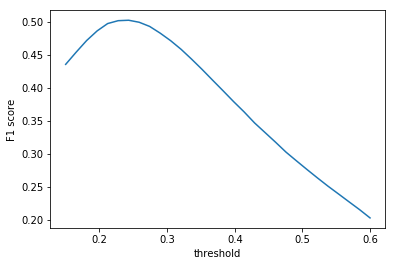

In [54]:
def plot_fl(model, feat):    
    thres = np.linspace(0.15,0.6,30)

    # The second column contains probabiity of positive
    proba_holdout = model.predict_proba(X_holdout[feat].values)[:,1]

    y = [computeF1(proba_holdout, y_holdout, t) for t in thres]
    plt.plot(thres, y)
    plt.ylabel("F1 score")
    plt.xlabel("threshold")
    
plot_fl(lr, X_holdout.columns)
#according to the result, when the threshold = 0.24 we can get the best f1 score 0.5

In [55]:
proba_holdout = lr.predict_proba(X_holdout[X_holdout.columns].values)[:,1]

In [62]:
computeF1(proba_holdout, y_holdout.values, 0.24)
#Best f1 score when the threshold = 0.24

0.5034314810715077

In [63]:
y_pred_lr = proba_holdout > 0.24

auclr =accuracy_score(y_holdout.values,y_pred_lr)
print(accuracy_score(y_holdout.values,y_pred_lr))
# score is the same as the probabilities
y_score_lr = proba_holdout

0.7656479719392515


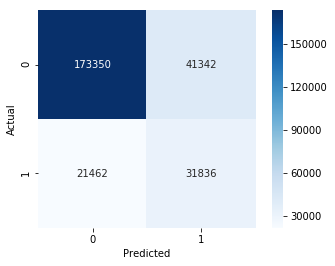

In [65]:
from sklearn.metrics import confusion_matrix

def cnf_mtx(probs, threshold):
    labels = [0, 1]
    y_true = y_holdout.values
    y_pred = probs > threshold
    y_pred = y_pred.astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred, labels)
    sns.heatmap(cnf_matrix, annot=True, xticklabels = labels, yticklabels = labels, cmap = 'Blues', fmt='g', square = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
cnf_mtx(proba_holdout, 0.24)

In [66]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_lr))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_lr))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_lr))

	Precision: 0.435
	Recall: 0.597
	F1: 0.503



In [67]:
#Based on the feature selection, we only select the top 10 features 
#'avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','times_ord','tot_orders'

In [68]:
X_train_f = X_train[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]
X_holdout_f = X_holdout[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]


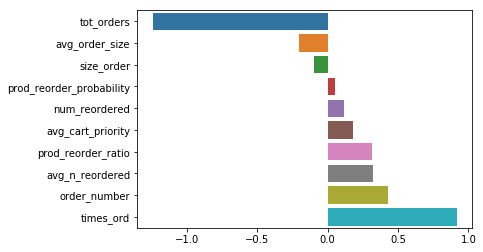

In [69]:
featuresTrain_f = featuresTrain[['avg_cart_priority','avg_n_reordered','avg_order_size','num_reordered','order_number','prod_reorder_probability','prod_reorder_ratio','size_order','tot_orders','times_ord']]

lr_f = LogisticRegression()
lr_f.fit(X_train_f.values, y_train.values)

coeffs = (lr_f.coef_.ravel()*featuresTrain_f.std()).sort_values()

sns.barplot(coeffs.values, coeffs.index)

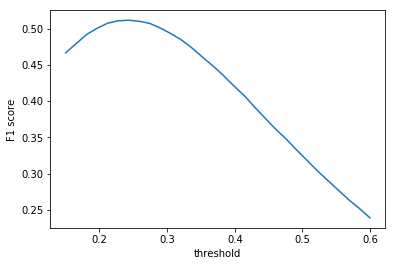

In [70]:
plot_fl(lr_f, X_holdout_f.columns)

In [71]:
proba_holdout_f = lr_f.predict_proba(X_holdout_f[X_holdout_f.columns].values)[:,1]

In [79]:
computeF1(proba_holdout_f, y_holdout.values, 0.24)
#the f1 score slightly increased from 0.50 to 0.5237 after feature selection when the threshold = 0.25 

0.5118110236220472

In [80]:
y_pred_lr_f = proba_holdout_f > 0.24

auclr_f =accuracy_score(y_holdout.values,y_pred_lr_f)
print(accuracy_score(y_holdout.values,y_pred_lr_f))
# score is the same as the probabilities
y_score_lr_f = proba_holdout_f

0.763558341729169


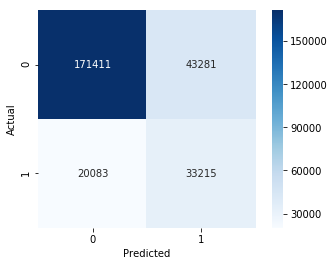

In [81]:
cnf_mtx(proba_holdout_f, 0.24)

In [82]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_lr_f))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_lr_f))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_lr_f))

	Precision: 0.434
	Recall: 0.623
	F1: 0.512



### XGBoost Model and Model Tuning 

In [87]:
xgb_model = xgb.XGBClassifier(max_depth=6, n_estimators=2000, learning_rate=0.05, nthread=-1)

eval_set = [(X_holdout, y_holdout)]

xgb_model.fit(X_train, y_train, early_stopping_rounds=50, 
        eval_metric=["auc"], eval_set=eval_set)


[0]	validation_0-auc:0.792944
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.794812
[2]	validation_0-auc:0.798546
[3]	validation_0-auc:0.799303
[4]	validation_0-auc:0.800278
[5]	validation_0-auc:0.800567
[6]	validation_0-auc:0.800795
[7]	validation_0-auc:0.801431
[8]	validation_0-auc:0.801814
[9]	validation_0-auc:0.802177
[10]	validation_0-auc:0.80239
[11]	validation_0-auc:0.802719
[12]	validation_0-auc:0.802716
[13]	validation_0-auc:0.803066
[14]	validation_0-auc:0.803269
[15]	validation_0-auc:0.803661
[16]	validation_0-auc:0.803516
[17]	validation_0-auc:0.80392
[18]	validation_0-auc:0.803963
[19]	validation_0-auc:0.804195
[20]	validation_0-auc:0.804606
[21]	validation_0-auc:0.805008
[22]	validation_0-auc:0.805245
[23]	validation_0-auc:0.805598
[24]	validation_0-auc:0.805674
[25]	validation_0-auc:0.805889
[26]	validation_0-auc:0.805959
[27]	validation_0-auc:0.806202
[28]	validation_0-auc:0.806351
[29]	validation_0-auc:0.806438
[30]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

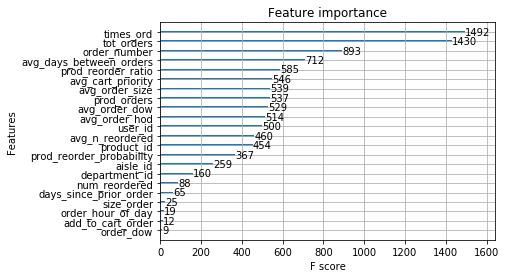

In [84]:
xgb.plot_importance(xgb_model, max_num_features=23)

In [85]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

# predict output with the test set
y_pred_XGB = xgb_model.predict(X_holdout)
# calculate xgboost classifier probabilities
y_prob_XGB = xgb_model.predict_proba(X_holdout)[:, 1]
aucxgb = accuracy_score(y_holdout,y_pred_XGB)
print("AUC Score : %f" % roc_auc_score(y_holdout, y_prob_XGB))
print("Accuracy : %.4g" % accuracy_score(y_holdout, y_pred_XGB))
# score is the same as the probabilities
y_score_XGB = y_prob_XGB

AUC Score : 0.809670
Accuracy : 0.8259


In [86]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_XGB))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_XGB))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_XGB))

	Precision: 0.641
	Recall: 0.282
	F1: 0.392



In [325]:
f1_xgb = f1_score(y_holdout, y_pred_XGB)

Thresh=0.000, n=23, Accuracy: 82.52%
Thresh=0.001, n=22, Accuracy: 82.52%
Thresh=0.001, n=21, Accuracy: 82.52%
Thresh=0.001, n=20, Accuracy: 82.52%
Thresh=0.002, n=19, Accuracy: 82.52%
Thresh=0.007, n=18, Accuracy: 82.52%
Thresh=0.011, n=17, Accuracy: 82.53%
Thresh=0.012, n=16, Accuracy: 82.52%
Thresh=0.019, n=15, Accuracy: 82.52%
Thresh=0.035, n=14, Accuracy: 82.52%
Thresh=0.036, n=13, Accuracy: 82.51%
Thresh=0.040, n=12, Accuracy: 82.50%
Thresh=0.045, n=11, Accuracy: 82.46%
Thresh=0.047, n=10, Accuracy: 82.46%
Thresh=0.048, n=9, Accuracy: 82.47%
Thresh=0.048, n=8, Accuracy: 82.56%
Thresh=0.050, n=7, Accuracy: 82.55%
Thresh=0.054, n=6, Accuracy: 82.59%
Thresh=0.055, n=5, Accuracy: 82.57%
Thresh=0.072, n=4, Accuracy: 82.61%
Thresh=0.105, n=3, Accuracy: 82.59%
Thresh=0.149, n=2, Accuracy: 82.55%
Thresh=0.163, n=1, Accuracy: 80.11%


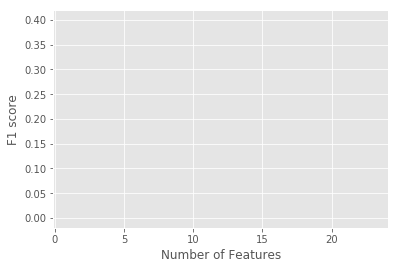

In [340]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(xgb_model.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
# eval model
    select_X_test = selection.transform(X_holdout)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_holdout, predictions)
    y = f1_score(y_holdout, predictions)
    plt.plot(select_X_train.shape[1], y)
    plt.ylabel("F1 score")
    plt.xlabel("Number of Features")
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

    

In [342]:
#from sklearn.model_selection import GridSearchCV

#param_dict = {'max_depth':[2,4,6,8], 'n_estimators':[1000,1500, 2000, 2500]} 
#rgs = GridSearchCV(xgb_model, param_dict) 
#rgs.fit(X_train, y_train) 
#print(rgs.best_score_)
 
#print(rgs.best_params_)


### Random Forest Model and Model Tuning 

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# random forest classifier object instantiation with default setting, i.e. max_depth is not set to anything
# the default setting overfit each tree to the training set, no limit set for max_depth
rnd_clf = RandomForestClassifier(n_estimators=2000, n_jobs=1, max_depth = 6, random_state=0)
# fit the data using the training set
rnd_clf.fit(X_train, y_train)
# calculate random forest classifier probabilities
y_prob_rf = rnd_clf.predict_proba(X_holdout)
# predict output with the test set
y_pred_rf = rnd_clf.predict(X_holdout)
# determine accuracy score for the random forest classifier
aucrf = accuracy_score(y_holdout,y_pred_rf)
print(accuracy_score(y_holdout,y_pred_rf))
# score is the same as the probabilities
y_score_rf = y_prob_rf[:,1]


In [343]:
print("\tPrecision: %1.3f" % precision_score(y_holdout, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_holdout, y_pred_rf))
print("\tF1: %1.3f\n" % f1_score(y_holdout, y_pred_rf))

	Precision: 0.450
	Recall: 0.001
	F1: 0.002



In [324]:
f1_rf = f1_score(y_holdout, y_pred_rf)

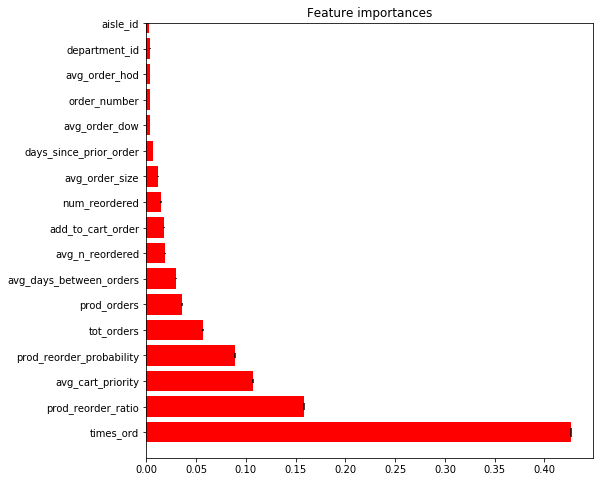

In [104]:
importances = rnd_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X_train.shape[1] -6):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]-6), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]-7])
plt.show()

In [ ]:
#RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = 1, random_state=42)

param_dict_rf = {'max_depth':[1,2,4,6,8], 'n_estimators':[500,1000,1500, 2000, 2500]}
 
rgs_rf = GridSearchCV(rnd_clf, param_dict_rf)
 
rgs_rf.fit(X_train, y_train)
 
print(rgs_rf.best_score_) 
print(rgs_rf.best_params_)


In [322]:
# calculate false postive, true postive rates and therehold  of the Xgboost model for ROC
fpr_XGB,tpr_XGB, threshold_XGB = roc_curve(y_holdout, y_score_XGB)

# calculate false postive, true postive rates and therehold of Logistic Regression model for ROC 
#fpr_lr,tpr_lr, threshold_lr = roc_curve(y_holdout, y_score_lr_f)

# calculate false postive, true postive rates and therehold of Random Forest model for ROC
fpr_rf,tpr_rf, threshold_rf = roc_curve(y_holdout, y_score_rf)

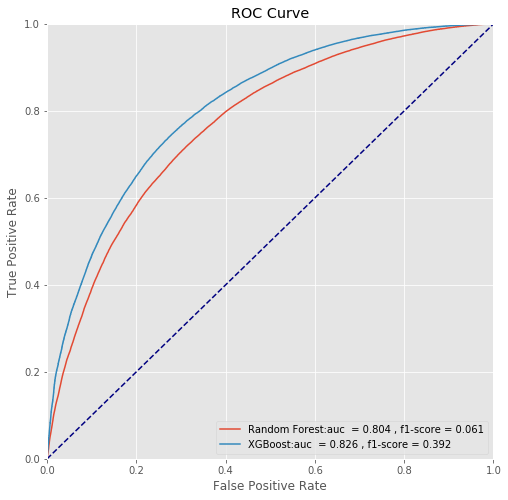

In [338]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

#plt.plot(fpr_lr,tpr_lr,label=' "Logsitic Regression:",auc  = %0.4f' % auclr_f)
plt.plot(fpr_rf,tpr_rf,label='Random Forest:auc  = {0:0.3f} , f1-score = {1:0.3f}'
             ''.format(aucrf, f1_rf) )
plt.plot(fpr_XGB,tpr_XGB,label='XGBoost:auc  = {0:0.3f} , f1-score = {1:0.3f}'
             ''.format(aucxgb, f1_xgb) )

# compare bagging method with standard decision tree classifier
# ROC curve plotting

# ROC curve plotting
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [311]:
#SORT BY PRODUCT RATIO AND PRODUCT PROBABILTY 
#WHEN REORDER = 1 , GROUPBY BY PRODUCT id THEN AVERAGE THE PROBABILTY OF THE RESULTS AND SORT THE HIGHEST ONES.
#since we get the best accurcy on the XGBoost model, we are going to take a look at the predicted data to see what types of products are likely to be reordered next time

In [312]:
predictoutcome = X_holdout.copy()
predictoutcome['predict_prob'] = xgb_model.predict_proba(X_holdout)[:, 1]
predictoutcome['prediction'] = y_pred_XGB
predict_reorder = predictoutcome[predictoutcome['prediction'] == 1]
test = list (predict_reorder['product_id'])
name = []
for i in range(0, len(test)): 
    name.append(list(products[products['product_id'] == test[i] ]['product_name'])[0])
predict_reorder['product_name'] = pd.Series(name).values

In [313]:
predict_reorder.head()

,product_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,size_order,num_reordered,...,avg_order_hod,tot_orders,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_ratio,predict_prob,prediction,product_name
2053,35503,3,41155,7,6,20,20.0,0,14,5,...,3.65625,8,91,16,718,0.516908,0.711699,0.532168,1,Organic Vanilla Almond Milk
2054,35503,1,41155,6,0,17,30.0,1,8,7,...,3.65625,8,91,16,718,0.516908,0.711699,0.526929,1,Organic Vanilla Almond Milk
2055,35503,5,41155,2,0,12,7.0,1,16,3,...,3.65625,8,91,16,718,0.516908,0.711699,0.512745,1,Organic Vanilla Almond Milk
2056,35503,4,41155,4,0,11,6.0,1,9,9,...,3.65625,8,91,16,718,0.516908,0.711699,0.512745,1,Organic Vanilla Almond Milk
2057,35503,7,41155,5,0,12,30.0,1,12,3,...,3.65625,8,91,16,718,0.516908,0.711699,0.516252,1,Organic Vanilla Almond Milk


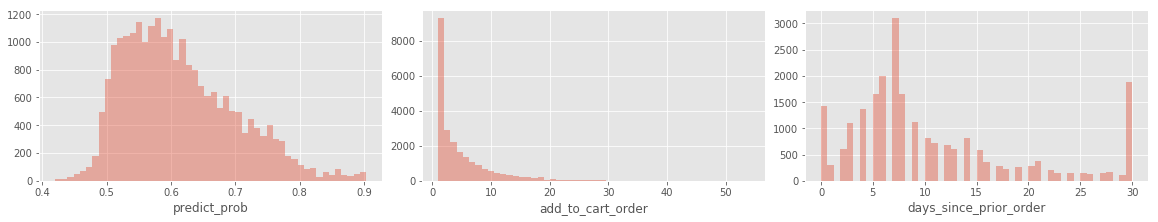

In [314]:
df = predict_reorder[['predict_prob','add_to_cart_order','days_since_prior_order']]
df.head()
#histogram
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 3))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.distplot(v, ax=axs[index], kde=0, norm_hist=0)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [315]:
grouped1=predict_reorder['prediction'].groupby(predict_reorder['product_name']).count()
grouped1 = grouped1.sort_values(ascending= False)
grouped1= pd.DataFrame(grouped1).reset_index()
grouped1.columns = ['product_name', 'Frequency']

In [339]:
grouped1.head(40)

,product_name,Frequency
0,Banana,1669
1,Bag of Organic Bananas,1230
2,Organic Whole Milk,464
3,Organic Hass Avocado,375
4,Organic Strawberries,356
5,Organic Baby Spinach,353
6,Organic Avocado,351
7,Organic Half & Half,209
8,Organic Raspberries,197
9,Sparkling Natural Mineral Water,171
